In [1]:
import torch
import dill
import matplotlib.pyplot as plt
from diffusion_policy.policy.diffusion_unet_timm_policy import DiffusionUnetTimmPolicy
from diffusion_policy.model.vision.timm_obs_encoder import TimmObsEncoder
import hydra

2024-11-17 18:57:12.678487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 18:57:12.741803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 18:57:13.778714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/michael-lutz/miniconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/michael-lutz/miniconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106det

In [2]:
ckpt_path = "/home/michael-lutz/umi_checkpoints/cup_policy/cup_wild_vit_l_1img.ckpt"
payload = torch.load(open(ckpt_path, 'rb'), map_location='cpu', pickle_module=dill)

In [43]:
model = hydra.utils.instantiate(payload['cfg'].policy)
horizon = payload['cfg'].task.shape_meta.obs.camera0_rgb.horizon

vit will use the CLS token. feature_aggregation (attention_pool_2d) is ignored!


rgb keys:          ['camera0_rgb']
low_dim_keys keys: ['robot0_eef_pos', 'robot0_eef_rot_axis_angle', 'robot0_eef_rot_axis_angle_wrt_start', 'robot0_gripper_width']


In [22]:
obs_encoder = model.obs_encoder
vit = obs_encoder.key_model_map['camera0_rgb']

In [6]:
import zarr
from diffusion_policy.codecs.imagecodecs_numcodecs import register_codecs, JpegXl
register_codecs()

root = zarr.open('/data/cup_in_the_wild.zarr.zip')
print(root.tree())

numcodec 'imagecodecs_aec' already registered
numcodec 'imagecodecs_apng' already registered
numcodec 'imagecodecs_avif' already registered
numcodec 'imagecodecs_bitorder' already registered
numcodec 'imagecodecs_bitshuffle' already registered
numcodec 'imagecodecs_blosc' already registered
numcodec 'imagecodecs_blosc2' already registered
numcodec 'imagecodecs_brotli' already registered
numcodec 'imagecodecs_byteshuffle' already registered
numcodec 'imagecodecs_bz2' already registered
numcodec 'imagecodecs_cms' already registered
numcodec 'imagecodecs_deflate' already registered
numcodec 'imagecodecs_delta' already registered
numcodec 'imagecodecs_float24' already registered
numcodec 'imagecodecs_floatpred' already registered
numcodec 'imagecodecs_gif' already registered
numcodec 'imagecodecs_heif' already registered
numcodec 'imagecodecs_jetraw' already registered
numcodec 'imagecodecs_jpeg' already registered
numcodec 'imagecodecs_jpeg2k' already registered
numcodec 'imagecodecs_jpeg

/
 ├── data
 │   ├── camera0_rgb (699432, 224, 224, 3) uint8
 │   ├── robot0_demo_end_pose (699432, 6) float64
 │   ├── robot0_demo_start_pose (699432, 6) float64
 │   ├── robot0_eef_pos (699432, 3) float32
 │   ├── robot0_eef_rot_axis_angle (699432, 3) float32
 │   └── robot0_gripper_width (699432, 1) float32
 └── meta
     └── episode_ends (1447,) int64


In [10]:
from diffusion_policy.common.replay_buffer import ReplayBuffer

replay_buffer = ReplayBuffer.create_from_group(root)
replay_buffer.n_episodes
ep = replay_buffer.get_episode(0)
ep.keys()

dict_keys(['camera0_rgb', 'robot0_demo_end_pose', 'robot0_demo_start_pose', 'robot0_eef_pos', 'robot0_eef_rot_axis_angle', 'robot0_gripper_width'])

In [12]:
ep['camera0_rgb'].shape

(400, 224, 224, 3)

In [24]:
ep['camera0_rgb'][0]

array([[[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 3, 0],
        [0, 2, 0],
        [1, 2, 0]],

       [[0, 1, 1],
        [0, 1, 1],
        [1, 1, 1],
        ...,
        [0, 3, 0],
        [1, 3, 0],
        [0, 2, 0]],

       [[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 3, 0],
        [0, 2, 0],
        [0, 2, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [38]:
obs_encoder.key_transform_map['camera0_rgb']

Sequential(
  (0): RandomCrop(size=(212, 212), padding=None)
  (1): Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
  (2): ColorJitter(brightness=(0.7, 1.3), contrast=(0.6, 1.4), saturation=(0.5, 1.5), hue=(-0.08, 0.08))
)

In [85]:
def process_img(img):
    img = ep["camera0_rgb"][:1]
    img = img.transpose(0, 3, 1, 2)
    img = torch.from_numpy(img)
    img = obs_encoder.key_transform_map['camera0_rgb'](img)
    img = img.numpy()
    return img

In [54]:
img = ep["camera0_rgb"][:1]
B, T = img.shape[:2]
C = img.shape[-1]
img = img.reshape(B, C, T, T)
img = torch.from_numpy(img)

img = obs_encoder.key_transform_map['camera0_rgb'](img)
plt.imshow(img[0].reshape(T, T, C))
plt.show()
img.shape


torch.Size([1, 3, 224, 224])

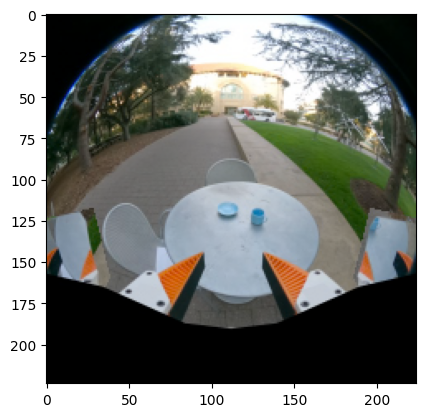

In [59]:
# visualize image
import matplotlib.pyplot as plt
plt.imshow(ep["camera0_rgb"][:1][0])
plt.show()

In [61]:
img[0].permute(1, 2, 0).shape

torch.Size([224, 224, 3])

In [76]:
obs_encoder.key_transform_map['camera0_rgb'][0]

RandomCrop(size=(212, 212), padding=None)

(1, 3, 224, 224)


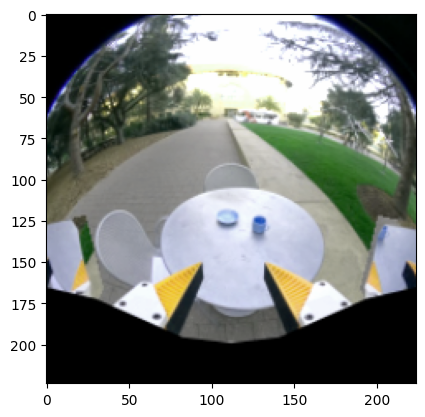

In [84]:
img = ep["camera0_rgb"][:1]
B, T = img.shape[:2]
C = img.shape[-1]
img = img.transpose(0, 3, 1, 2)
img = torch.from_numpy(img)
img = obs_encoder.key_transform_map['camera0_rgb'](img)
img = img.numpy()
print(img.shape)
plt.imshow(img[0].transpose(1, 2, 0))
plt.show()